# Mid Circuit Measurement Debug
Let's try to understand better what PennyLane is internally doing considering only two classes.  

In [1]:
import torch
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from data_utils import mnist_preparation 
from evaluationUtils import calculate_mcm_accuracy
from tqdm import tqdm
import matplotlib as plt
from OriginalModel import FullQuantumModel, QuantumCircuit
from mcmModel import MCMQuantumModel, MCMCircuit
from pennylane import Device
from pennylane.measurements import StateMP
from torch.nn import Module, ParameterDict
import matplotlib.pyplot as plt
import warnings
from typing import Optional, Dict, List, Any
from torch.utils.data import DataLoader, dataloader
from time import time
import math
from pennylane.measurements import MidMeasureMP
torch.manual_seed(1234)

First of all let's import data with train/validation/test split of 70/15/15. 

In [2]:
labels = [0,1]
# Download MNIST and prepare transforms
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
                                transforms.Resize((16, 16)),  # Resize to 16x16
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))  # Normalize
                             ]))
#train/vali/test 70/15/15 split, see data_utils.py for further details
train_dataloader, validation_dataloader, test_dataloader = mnist_preparation(dataset=mnist, labels = labels, train_test_ratio=0.7,batch_size=64, vali_test_ratio=0.5)

print("Images in the training set: ", len(train_dataloader.dataset), "\n Images in the validation set: ", len(validation_dataloader.dataset), "\n Images in the test set: ", len(test_dataloader.dataset))

Images in the training set:  8865 
 Images in the validation set:  1900 
 Images in the test set:  1900


# Baseline Model

See [OriginalModel.py](https://github.com/JackVittori/QML-early_exit/blob/main/OriginalModel.py) for further details. Highlights are hereafter reported: 

- a layer is composed by RX, RY, RZ rotations on each qubit and CNOT gates to create entanglement (24 params x layer); 
- the quantum circuit return is the quantum state;
- probability is extracted from the first qubit using the following Python code (the first 128 states are associated to measuring 0 on the first qubit, the others to measuring 1):   
```python 
if self.num_classes == 2:
    state_vector = self.quantum_layer(state=state, num_layers_to_execute=num_layers_to_execute)
    probabilities = torch.sum(torch.abs(state_vector[:, :2 ** (self.quantum_layer.num_qubits - 1)]) ** 2, dim=1)
    return probabilities.type(torch.float32)
```
- train with ```python torch.nn.BCELoss()```

Trainable parameters: 192


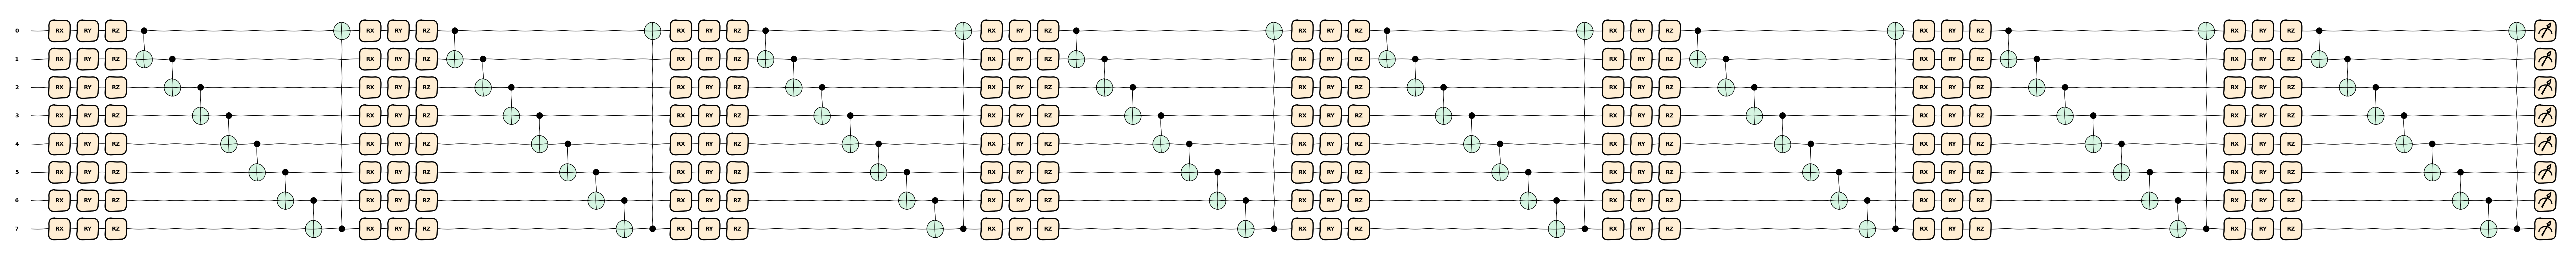

In [6]:
baseline = FullQuantumModel(qubits=8, layers=8, num_classes=2)
baseline.trainable_parameters()
baseline.draw(style='sketch')

In [14]:
#We could freeze a layer if we want with the following method of the class in OriginalModel.py
baseline.freeze_layers([0,1])
baseline.trainable_layers()
baseline.trainable_parameters()

{'layer_0': False, 'layer_1': False, 'layer_2': True, 'layer_3': True, 'layer_4': True, 'layer_5': True, 'layer_6': True, 'layer_7': True}
Trainable parameters: 144


In [15]:
# We can also unfreeze them
baseline.unfreeze_layers([0,1])
baseline.trainable_layers()
baseline.trainable_parameters()

{'layer_0': True, 'layer_1': True, 'layer_2': True, 'layer_3': True, 'layer_4': True, 'layer_5': True, 'layer_6': True, 'layer_7': True}
Trainable parameters: 192


In [ ]:
accuracy_history, loss_history = baseline.fit(dataloader=train_dataloader, learning_rate=0.001, epochs=10, show_plot=True)

## Baseline evaluation

In [17]:
baseline.freeze_layers([0,1,2,3,4,5,6,7])
baseline.trainable_parameters()

#simplified per image test set evaluation
result = []
for img, label in tqdm(test_dataloader.dataset):
    img = img / torch.linalg.norm(img).view(-1, 1) #image normalization
    probs = torch.round(baseline.forward(state=img)) #extract probabilities
    result.append((probs, label))
    
def calculate_accuracy(data):
    correct = sum([1 for label, prediction in data if label == prediction])
    return correct, correct / len(data)

test_results = calculate_accuracy(result)

print(test_results[0], "elements have been correctly classified over", len(test_dataloader.dataset), "total images with an accuracy of ", test_results[1])

Trainable parameters: 0


100%|██████████| 1900/1900 [00:30<00:00, 62.00it/s]

1886 elements have been correctly classified over 1900 total images with an accuracy of  0.9926315789473684


# MCM model



In [8]:
mcm_model = MCMQuantumModel(qubits=8, layers=8, ansatz='2-class')

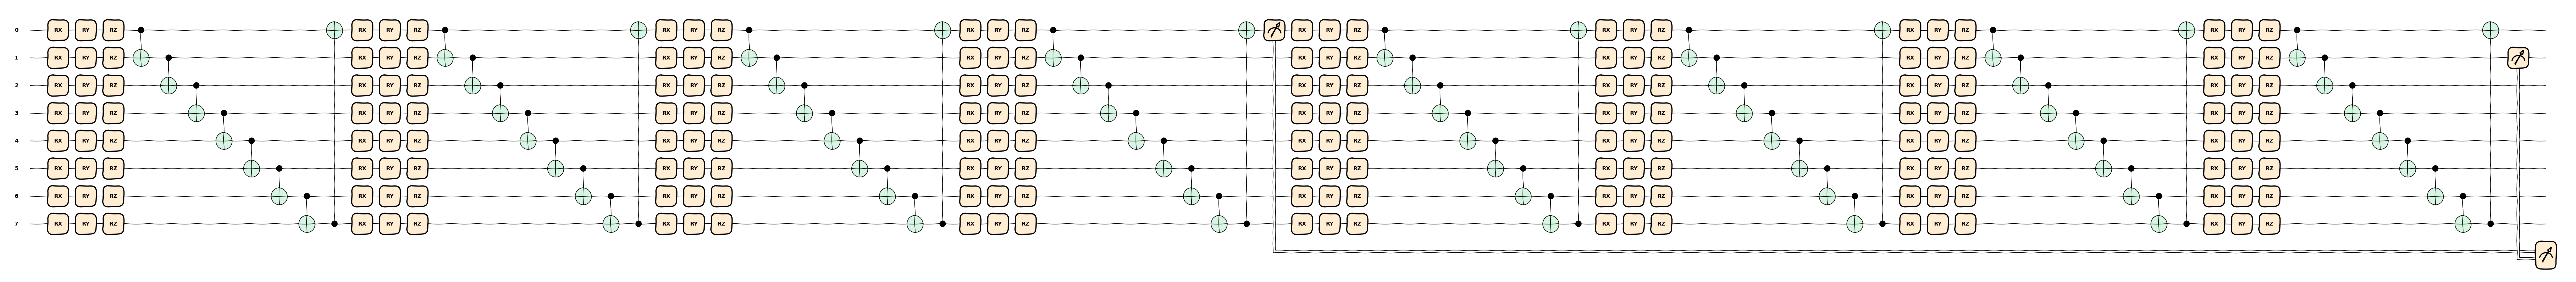

In [9]:
mcm_model.draw(style='sketch', path="mcm_model.png")

Epoch 1/10: 100%|██████████| 138/138 [00:20<00:00,  6.66it/s, fm_accuracy=1, loss=0.731, mcm_accuracy=1]        


Time per epoch (s):  20.710078954696655
Epoch:  1 Loss:  0.7379108162029929
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9954710144927537
--------------------------------------------------------------------------
Final Measurement accuracy:  0.993546195652174
--------------------------------------------------------------------------


Epoch 2/10: 100%|██████████| 138/138 [00:21<00:00,  6.51it/s, fm_accuracy=0.984, loss=0.737, mcm_accuracy=0.984]


Time per epoch (s):  21.184104204177856
Epoch:  2 Loss:  0.7284255183261373
--------------------------------------------------------------------------
Mid circuit accuracy:  0.995697463768116
--------------------------------------------------------------------------
Final Measurement accuracy:  0.994338768115942
--------------------------------------------------------------------------


Epoch 3/10: 100%|██████████| 138/138 [00:21<00:00,  6.48it/s, fm_accuracy=1, loss=0.678, mcm_accuracy=1]        


Time per epoch (s):  21.2968590259552
Epoch:  3 Loss:  0.7109143319337264
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9953577898550725
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9952445652173914
--------------------------------------------------------------------------


Epoch 4/10: 100%|██████████| 138/138 [00:21<00:00,  6.41it/s, fm_accuracy=1, loss=0.706, mcm_accuracy=1]        


Time per epoch (s):  21.534076929092407
Epoch:  4 Loss:  0.6903303088485331
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9952445652173914
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9950181159420289
--------------------------------------------------------------------------


Epoch 5/10: 100%|██████████| 138/138 [00:21<00:00,  6.45it/s, fm_accuracy=1, loss=0.674, mcm_accuracy=1]        


Time per epoch (s):  21.395975351333618
Epoch:  5 Loss:  0.6726175352283146
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9950181159420289
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9952445652173914
--------------------------------------------------------------------------


Epoch 6/10: 100%|██████████| 138/138 [00:21<00:00,  6.46it/s, fm_accuracy=1, loss=0.623, mcm_accuracy=1]        


Time per epoch (s):  21.348013639450073
Epoch:  6 Loss:  0.6606387241163115
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9946784420289855
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9949048913043478
--------------------------------------------------------------------------


Epoch 7/10: 100%|██████████| 138/138 [00:21<00:00,  6.47it/s, fm_accuracy=1, loss=0.641, mcm_accuracy=1]        


Time per epoch (s):  21.335893869400024
Epoch:  7 Loss:  0.651800937410714
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9947916666666666
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9953577898550725
--------------------------------------------------------------------------


Epoch 8/10: 100%|██████████| 138/138 [00:21<00:00,  6.46it/s, fm_accuracy=1, loss=0.664, mcm_accuracy=1]        


Time per epoch (s):  21.3601291179657
Epoch:  8 Loss:  0.6461733121802842
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9944519927536232
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9946784420289855
--------------------------------------------------------------------------


Epoch 9/10: 100%|██████████| 138/138 [00:21<00:00,  6.42it/s, fm_accuracy=1, loss=0.639, mcm_accuracy=1]        


Time per epoch (s):  21.50259304046631
Epoch:  9 Loss:  0.6426848890124888
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9945652173913043
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9944519927536232
--------------------------------------------------------------------------


Epoch 10/10: 100%|██████████| 138/138 [00:22<00:00,  6.27it/s, fm_accuracy=0.984, loss=0.626, mcm_accuracy=0.984]


Time per epoch (s):  22.021179914474487
Epoch:  10 Loss:  0.6400280296802521
--------------------------------------------------------------------------
Mid circuit accuracy:  0.9942255434782609
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9939990942028986
--------------------------------------------------------------------------


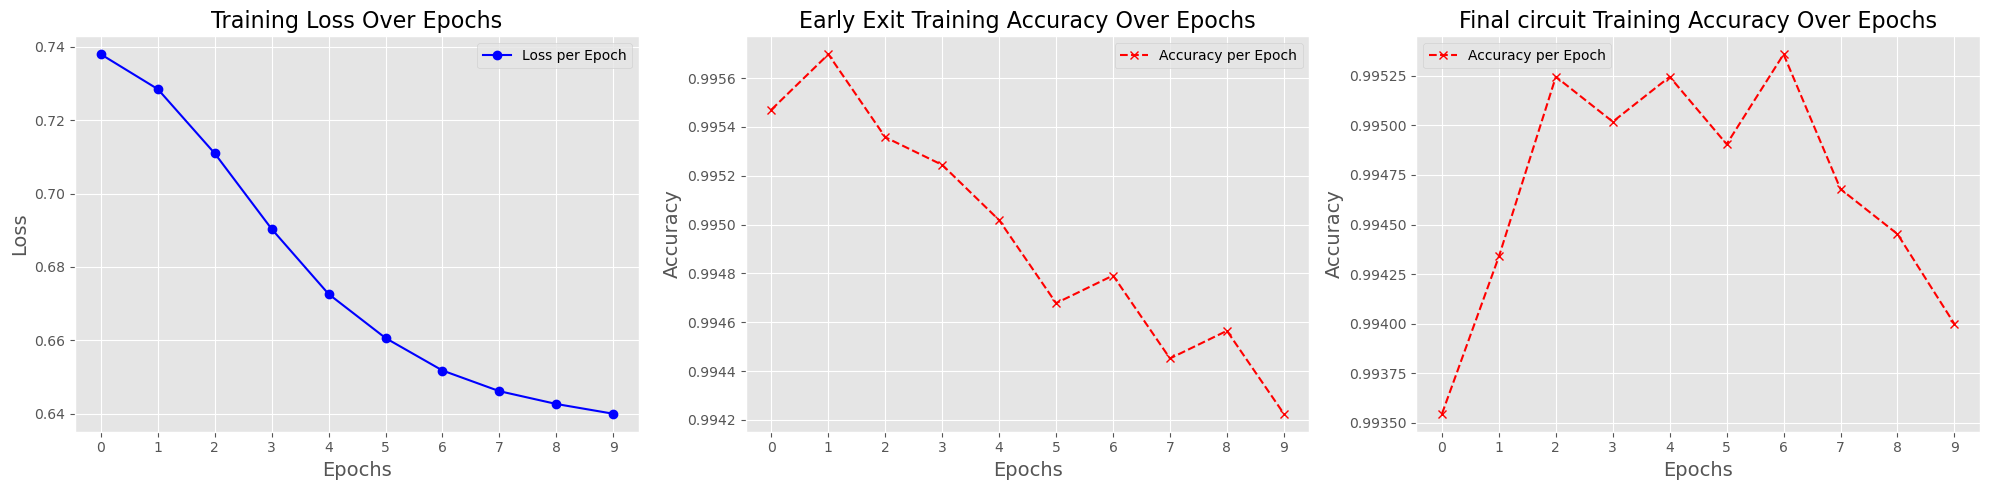

In [12]:
mcm_accuracy, fm_accuracy, loss_history = mcm_model.fit(dataloader=train_dataloader, learning_rate=0.001, epochs=10, show_plot=True)

## Full Evaluation Circuit
Let's first try to execute every time the circuit for each image as it was trained, post-selecting the exit varying the threshold.  

In [82]:
prediction_results = {"early": [], "final": []}
for img, target in tqdm(test_dataloader.dataset):
    #img normalization
    img = img / torch.linalg.norm(img).view(-1, 1)
    #probs extraction
    mcm_probs, final_probs = mcm_model.forward(state=img)
    #mcm prediction and confidence
    mcm_predictions = torch.argmax(mcm_probs, dim=1)
    mcm_correct = mcm_predictions == target
    early_confidence = mcm_probs[0,mcm_predictions]
    prediction_results["early"].append((mcm_correct, early_confidence))
    
    #fm prediction
    final_predictions = torch.argmax(final_probs, dim=1)
    final_correct = final_predictions == target
    prediction_results["final"].append((final_correct))

100%|██████████| 1900/1900 [00:43<00:00, 43.29it/s]


`results['early']` will contain a list of tensors containing: 
- a boolean containing a True if the prediction was correct; 
- the confidence measure associated to measure 0 if 0 was predicted, associated to 1 if 1 was predicted


`results['final']` is a list of booleans containing True if the prediction was correct and Falso if it was uncorrect. 

Let's try to post select the exit varying the threshold, taking early prediction when the probability associated to the early prediciton is above a threshold and the final prediction when the condition is not satisfied: 

In [83]:
def post_evaluation_threshold(early_results, final_results, threshold):
    results = [] #chosen prediction per image
    count_1 = 0 #counter for early classified images
    count_2 = 0 #counter for final classified images
    mcm_correct = 0 #counter for correctly early classified images 
    final_correct = 0 #counter for correctly final classified images
    
    for i, (early_bool, confidence) in enumerate(early_results):
        if confidence.item() > threshold:
            results.append(early_bool.item()) #use early prediction
            count_1 += 1
            if early_bool: 
                mcm_correct += 1
        else:
            results.append(final_results[i][0].item()) #use final prediction
            count_2 += 1
            if final_results[i][0].item():
                final_correct += 1
            
    return results, mcm_correct, count_1, final_correct, count_2

In [113]:
def explain_results(results: Dict, threshold: List[float]):
    summary_data = {
        'Threshold': [],
        'Total Accuracy': [],
        'Early Classified': [],
        'Early Accuracy': [],
        'Final Classified': [],
        'Final Accuracy': []}
    
    for t in threshold:
        prediction_result, mcm_correct, n_early, final_correct, n_final = post_evaluation_threshold(results['early'], results['final'], t)

        tot_accuracy = sum([1 for i in prediction_result if i == True]) / len(prediction_result)
        
        #avoid division by 0
        early_accuracy = mcm_correct / n_early if n_early > 0 else 0
        final_accuracy = final_correct / n_final if n_final > 0 else 0

        summary_data['Threshold'].append(t)
        summary_data['Total Accuracy'].append(tot_accuracy)
        summary_data['Early Classified'].append(n_early)
        summary_data['Early Accuracy'].append(early_accuracy)
        summary_data['Final Classified'].append(n_final)
        summary_data['Final Accuracy'].append(final_accuracy)
        # print(f" tot accuracy {tot_accuracy}, average mean, {(n_early*early_accuracy + n_final*final_accuracy)/(n_early + n_final)}")
    
    df = pd.DataFrame(summary_data)
    return df

In [114]:
#threshold definition
threshold = [round(x * 0.02 + 0.3, 2) for x in range(31)]

In [115]:
explain_results(prediction_results, threshold)

,Threshold,Total Accuracy,Early Classified,Early Accuracy,Final Classified,Final Accuracy
0,0.30,0.991053,1900,0.991053,0,0.000000
1,0.32,0.991053,1900,0.991053,0,0.000000
2,0.34,0.991053,1900,0.991053,0,0.000000
3,0.36,0.991053,1900,0.991053,0,0.000000
4,0.38,0.991053,1900,0.991053,0,0.000000
5,0.40,0.991053,1900,0.991053,0,0.000000
6,0.42,0.991053,1900,0.991053,0,0.000000
7,0.44,0.991053,1900,0.991053,0,0.000000
8,0.46,0.991053,1900,0.991053,0,0.000000
9,0.48,0.991053,1900,0.991053,0,0.000000
